In [1]:
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from keras.layers import LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\anaconda\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.


In [2]:
pkl_file = open("RML2016.10a_dict.pkl",'rb')
Xd = pickle.load(pkl_file, encoding='bytes')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [3]:
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
trainy =list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [4]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [5]:
dr = 0.5 # 设置dropout参数，50%神经元不工作，防止过拟合  
#搭建Keras Sequential 顺序模型  
model = models.Sequential()  
#模型需要知道它所期望的输入的尺寸。出于这个原因，顺序模型中的第一层（且只有第一层，因为下面的层可以自动地推断尺寸）
#需要接收关于其输入尺寸的信息。  

#传递一个 input_shape 参数给第一层。  
model.add(Reshape([1]+in_shp, input_shape=in_shp))  
#使用了Zero-padding方法对数据边缘进行补零操作来控制输出特征图的大小  
model.add(ZeroPadding2D((0,2), dim_ordering='th'))  
#卷积层Conv1，采用128个1x3的卷积核，采用了ReLU函数作为激活函数  
model.add(Conv2D(128, (1, 3), padding='valid', activation="relu", name="conv1", init='glorot_uniform',data_format="channels_first")) 
#使用了Dropout方法来防止网络过拟合  
model.add(Dropout(dr))  
#补零  
model.add(ZeroPadding2D((0,2), dim_ordering='th'))  
#卷积层Conv2，采用32个2x3的卷积核  
model.add(Conv2D(32, (2, 3), padding='valid', activation="relu", name="conv2", init='glorot_uniform',data_format="channels_first"))  
#防止网络过拟合  
model.add(Dropout(dr))  
#修改数据尺寸以便作为LSTM层输入，将132作为LSTM网络中的输入序列的长度，32作为LSTM的序列维度进入到LSTM层中  
model.add(Reshape([32,-1]))  
#LSTM层  
model.add(LSTM(128))  
#dropout  
model.add(Dropout(dr))  
#全连接层，神经元个数128  
model.add(Dense(11, activation='relu', init='he_normal', name="dense_1"))  
#dropout  
#model.add(Dropout(dr))  
#使用SoftMax为激活函数对数据进行分类  
model.add(Activation('softmax'))  
#修改尺寸对应最后11个分类输出  
#model.add(Reshape([len(classes)]))  
#损失函数的计算采用交叉熵，优化器选择adam  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])  
model.summary()  


Instructions for updating:
Colocations handled automatically by placer.


D:\anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((0, 2), data_format="channels_first")`
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 3), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((0, 2), data_format="channels_first")`
  app.launch_new_instance()
D:\anaconda\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 3), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 2, 130)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 128, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 1, 132)        24608     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 1, 132)       

D:\anaconda\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, activation="relu", name="dense_1", kernel_initializer="he_normal")`


In [6]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [7]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'D:/文档类/毕设/数据集/convmodrecnets_CNN2_0.5.wts.h5'
# model.fit(X_train,
#     Y_train,
#     batch_size=batch_size,
#     epochs=nb_epoch)
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
#    show_accuracy=True,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])
# loss,accuracy=model.evaluate(X_test, Y_test)
# print('\nloss:',loss)
# print('accuracy:',accuracy)
# model.save(filepath)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Instructions for updating:
Use tf.cast instead.
Train on 110000 samples, validate on 110000 samples
Epoch 1/100
110000/110000 [==============================] - 401s 4ms/step - loss: 2.3838 - acc: 0.1138 - val_loss: 2.3386 - val_acc: 0.1451
Epoch 2/100
110000/110000 [==============================] - 409s 4ms/step - loss: 2.2133 - acc: 0.1685 - val_loss: 2.1589 - val_acc: 0.2159
Epoch 3/100
110000/110000 [==============================] - 385s 3ms/step - loss: 2.0931 - acc: 0.2241 - val_loss: 2.1071 - val_acc: 0.2251
Epoch 4/100
110000/110000 [==============================] - 366s 3ms/step - loss: 1.9852 - acc: 0.2556 - val_loss: 1.9204 - val_acc: 0.2823
Epoch 5/100
110000/110000 [==============================] - 360s 3ms/step - loss: 1.9191 - acc: 0.2769 - val_loss: 2.0680 - val_acc: 0.2785
Epoch 6/100
110000/110000 [==============================] - 359s 3ms/step - loss: 1.8616 - acc: 0.3006 - val_loss: 1.8117 - val_acc: 0.3245
Epoch 7/100
110000/110000 [===========================

110000/110000 [==============================] - 348s 3ms/step - loss: 1.2943 - acc: 0.4968 - val_loss: 1.2735 - val_acc: 0.5040
Epoch 57/100
110000/110000 [==============================] - 348s 3ms/step - loss: 1.2942 - acc: 0.4954 - val_loss: 1.2594 - val_acc: 0.5046
Epoch 58/100
110000/110000 [==============================] - 349s 3ms/step - loss: 1.2835 - acc: 0.4993 - val_loss: 1.2532 - val_acc: 0.5083
Epoch 59/100
110000/110000 [==============================] - 346s 3ms/step - loss: 1.2860 - acc: 0.4988 - val_loss: 1.2565 - val_acc: 0.5127
Epoch 60/100
110000/110000 [==============================] - 348s 3ms/step - loss: 1.2861 - acc: 0.5003 - val_loss: 1.2660 - val_acc: 0.5044
Epoch 61/100
110000/110000 [==============================] - 349s 3ms/step - loss: 1.2832 - acc: 0.4995 - val_loss: 1.2763 - val_acc: 0.5022
Epoch 62/100
110000/110000 [==============================] - 348s 3ms/step - loss: 1.2829 - acc: 0.5006 - val_loss: 1.2517 - val_acc: 0.5157
Epoch 63/100
110000

In [8]:
# model=load_model(filepath)
# loss,accuracy=model.evaluate(X_test, Y_test)
# print('\nloss:',loss)
# print('accuracy:',accuracy)

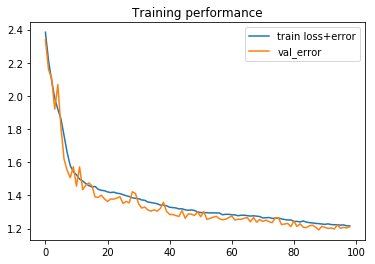

In [9]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [10]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

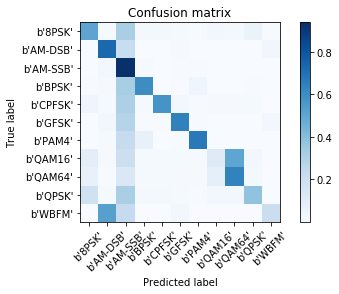

In [19]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


In [20]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

b'8PSK' 0.507456711039936
b'AM-DSB' 0.7339906383826312
b'AM-SSB' 0.9376701966717095
b'BPSK' 0.6030891169596586
b'CPFSK' 0.5724493846764589
b'GFSK' 0.6413032681037052
b'PAM4' 0.673507832639302
b'QAM16' 0.11701915403032721
b'QAM64' 0.6382056451612903
b'QPSK' 0.379875975195039
b'WBFM' 0.21003884075291307


Overall Accuracy:  0.09428879310344827
Overall Accuracy:  0.099105676218288
Overall Accuracy:  0.09935088351965381
Overall Accuracy:  0.11521580102414046
Overall Accuracy:  0.16371760500446828
Overall Accuracy:  0.24057384587088468
Overall Accuracy:  0.3718565088757396
Overall Accuracy:  0.49716791522017173
Overall Accuracy:  0.6021871638580136
Overall Accuracy:  0.7127814088598402
Overall Accuracy:  0.7680999632488056
Overall Accuracy:  0.7922714078374455
Overall Accuracy:  0.7906678865507777
Overall Accuracy:  0.8004035956705192
Overall Accuracy:  0.796655879180151
Overall Accuracy:  0.798006762769176
Overall Accuracy:  0.793009284543965
Overall Accuracy:  0.8016378525932666
Overall Accuracy:  0.7985414767547858
Overall Accuracy:  0.7981905465288035


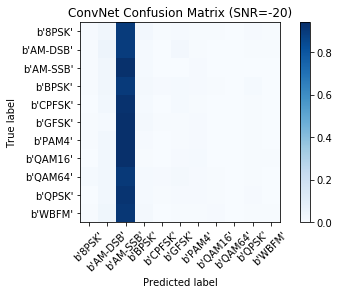

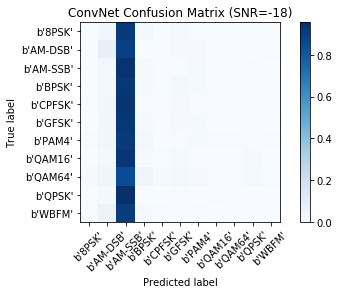

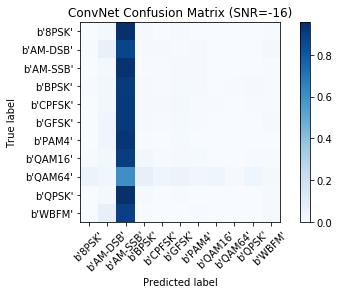

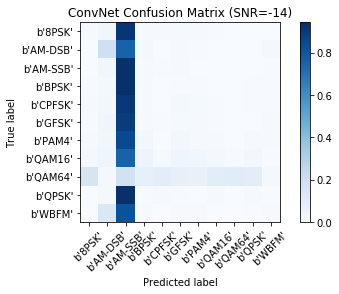

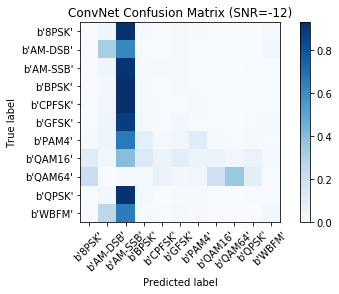

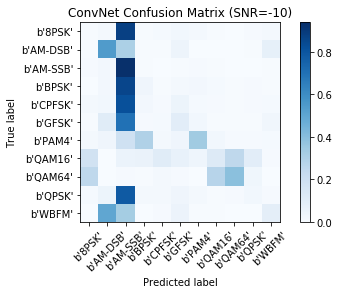

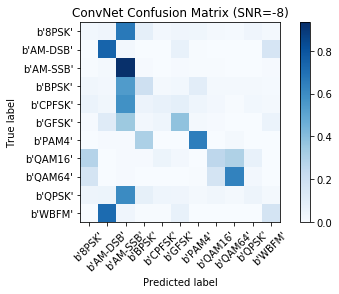

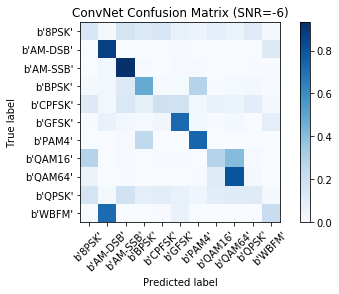

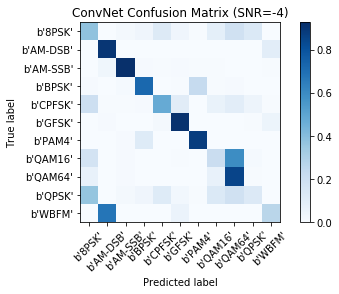

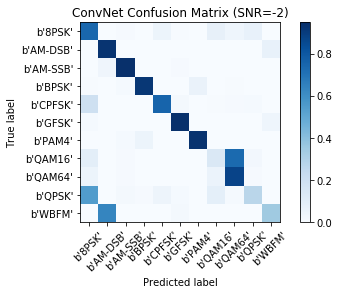

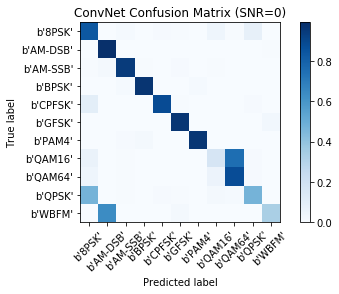

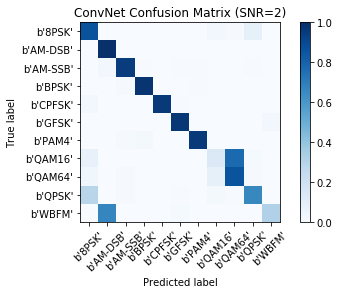

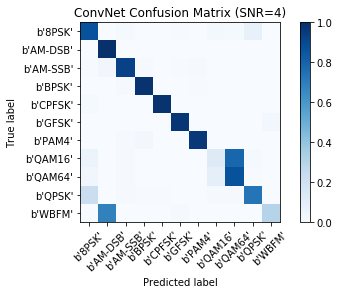

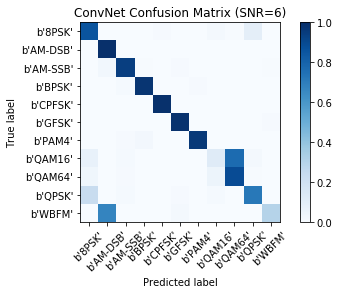

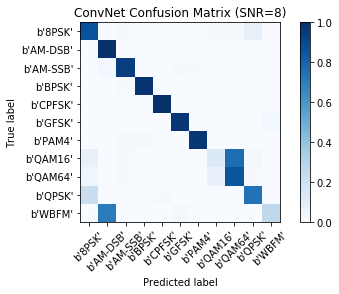

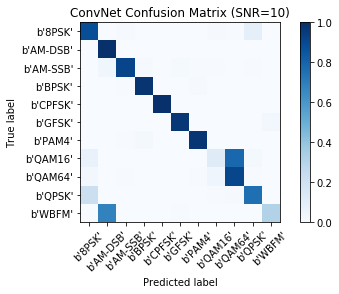

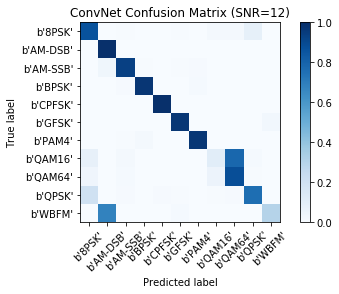

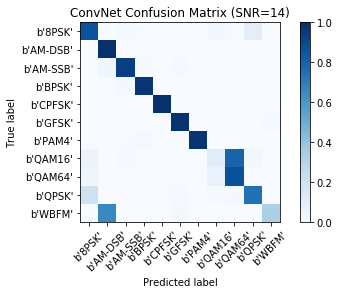

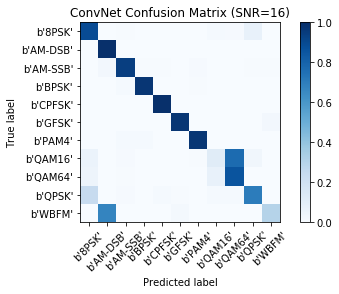

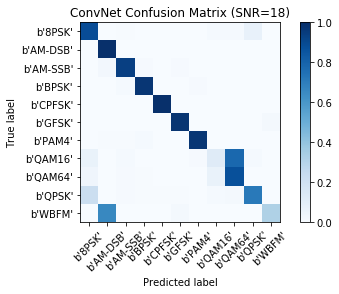

In [24]:
# Plot confusion matrix 画图
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
#    print(test_SNRs)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [25]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.09428879310344827, -18: 0.099105676218288, -16: 0.09935088351965381, -14: 0.11521580102414046, -12: 0.16371760500446828, -10: 0.24057384587088468, -8: 0.3718565088757396, -6: 0.49716791522017173, -4: 0.6021871638580136, -2: 0.7127814088598402, 0: 0.7680999632488056, 2: 0.7922714078374455, 4: 0.7906678865507777, 6: 0.8004035956705192, 8: 0.796655879180151, 10: 0.798006762769176, 12: 0.793009284543965, 14: 0.8016378525932666, 16: 0.7985414767547858, 18: 0.7981905465288035}


Text(0.5, 1.0, 'CNN_LSTM Classification Accuracy on RadioML 2016.10 Alpha')

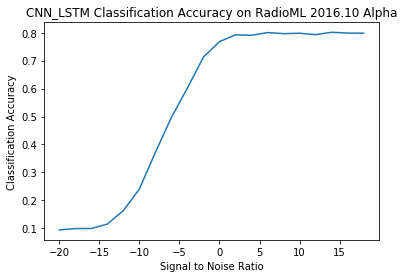

In [28]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN_LSTM Classification Accuracy on RadioML 2016.10 Alpha")